In [1]:
import gspread
from oauth2client.service_account import ServiceAccountCredentials

In [2]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt

In [3]:
#Import data from COVID Japan Live dataset
cldata = pd.read_json('https://raw.githubusercontent.com/reustle/covid19japan-data/master/docs/patient_data/2020-04-21.json', orient='columns')
cldata = cldata.filter(['dateAnnounced','ageBracket','gender','detectedPrefecture','patientStatus'])
cldata = cldata.set_index('dateAnnounced')

In [4]:
cldata.head()

,ageBracket,gender,detectedPrefecture,patientStatus
dateAnnounced,,,,
2020-01-15,30,M,Kanagawa,Recovered
2020-01-24,40,M,Tokyo,Recovered
2020-01-25,30,F,Tokyo,Recovered
2020-01-26,40,M,Aichi,NaN
2020-01-28,40,M,Aichi,Hospitalized


In [5]:
# Tidy to show new cases per day by prefecture
cldata.index = pd.to_datetime(cldata.index)
clnewcase = cldata.groupby([pd.Grouper(freq='1d'),'detectedPrefecture']).count()
clnewcase = clnewcase.filter(['ageBracket'])
clnewcase = clnewcase.rename(columns={'ageBracket':'New Cases'})

In [6]:
clnewcase.head()

,,New Cases
dateAnnounced,detectedPrefecture,
2020-01-15,Kanagawa,1
2020-01-24,Tokyo,1
2020-01-25,Tokyo,1
2020-01-26,Aichi,1
2020-01-28,Aichi,1


In [7]:
# Set dates for use in regression here
lmnewdata = clnewcase.loc['2020-04-14':'2020-04-19']
lmnewdata = lmnewdata.unstack(level=0)
lmnewdata.columns = lmnewdata.columns.droplevel(0)

In [8]:
lmnewdata.columns = lmnewdata.columns.astype(str)

In [9]:
lmnewdata.head()

dateAnnounced,2020-04-14,2020-04-15,2020-04-16,2020-04-17,2020-04-18,2020-04-19
detectedPrefecture,,,,,,
Aichi,10.0,12.0,14.0,10.0,18.0,11.0
Akita,1.0,NaN,NaN,NaN,NaN,NaN
Chiba,25.0,66.0,45.0,39.0,8.0,19.0
Ehime,2.0,1.0,NaN,NaN,3.0,1.0
Fukuoka,34.0,32.0,26.0,17.0,25.0,17.0


In [10]:
# Calculating % of males among cases in each prefecture
gendercalc = cldata.dropna(subset=['gender'])
gendercalc = gendercalc.groupby('detectedPrefecture')['gender'].value_counts(normalize=True).to_frame().rename(columns={'gender':'ratio'}).reset_index()
ratio = gendercalc[gendercalc['gender'] == 'M']

In [11]:
ratio.head()

,detectedPrefecture,gender,ratio
0,Aichi,M,0.583710
2,Akita,M,0.625000
5,Aomori,M,0.363636
6,Chiba,M,0.637807
9,Ehime,M,0.500000


In [12]:
# Creating dictionary of Prefecture:Male %
dict(zip(ratio.detectedPrefecture,ratio.ratio))
pd.Series(ratio.detectedPrefecture.values,index=ratio.ratio).to_dict()
gendict = ratio.set_index('detectedPrefecture').to_dict()['ratio']

In [13]:
# Append % of males among new cases to LR data
lmnewdata['maleRatio'] =  lmnewdata.index.map(gendict)

In [14]:
# Drop prefecture rows without cases for > 2/5 days and fill NaNs with 0
lmnewdata.columns = lmnewdata.columns.map(str)
lmnewdata = lmnewdata.dropna(thresh=6)
lmnewdata = lmnewdata.fillna(0)

In [15]:
lmnewdata['meanAge'] = cldata.groupby('detectedPrefecture')['ageBracket'].mean()

In [16]:
lmnewdata.index = lmnewdata.index.rename('Prefecture')

In [17]:
lmnewdata.head()

dateAnnounced,2020-04-14,2020-04-15,2020-04-16,2020-04-17,2020-04-18,2020-04-19,maleRatio,meanAge
Prefecture,,,,,,,,
Aichi,10.0,12.0,14.0,10.0,18.0,11.0,0.583710,46.653153
Chiba,25.0,66.0,45.0,39.0,8.0,19.0,0.637807,41.646341
Fukuoka,34.0,32.0,26.0,17.0,25.0,17.0,0.547059,42.345521
Fukushima,1.0,1.0,9.0,3.0,8.0,2.0,0.645161,43.225806
Gifu,8.0,3.0,5.0,1.0,1.0,2.0,0.506849,43.239726


In [18]:
# Get test data from Toyo Keizai Github
tests = pd.read_csv('https://raw.githubusercontent.com/kaz-ogiwara/covid19/master/data/prefectures.csv', error_bad_lines=False)

In [19]:
# Drop necessay columns
tests = tests.drop(columns={'testedPositive','discharged','deaths'})

In [20]:
# Rename "date" to "day" so date column can use datetime
tests = tests.rename(columns={'date':'day'})

In [21]:
tests.head()

,year,month,day,prefectureNameJ,prefectureNameE,peopleTested
0,2020,3,11,北海道,Hokkaido,1069.0
1,2020,3,11,青森県,Aomori,58.0
2,2020,3,11,岩手県,Iwate,20.0
3,2020,3,11,宮城県,Miyagi,94.0
4,2020,3,11,秋田県,Akita,40.0


In [22]:
# Convert date column to datetime
tests['Date'] = pd.to_datetime(tests[['year','month','day']])

In [23]:
# Drop now unnecessary columns
tests = tests.drop(columns=['year','month','day'])

In [24]:
# Set index to "Date" column
tests = tests.set_index('Date')

In [25]:
# Remove prefecture suffixes in Japanese precfecture names to match existing EN-JP dictionary
# NOTE: Previous versions of this data source did not include prefecture names in English, so this step was necessary.
tests['Prefecture'] = tests['prefectureNameJ'].map(lambda x: x.rstrip('県府'))

In [26]:
# Replace "Tokyo-to" with "Tokyo" (Tokyo uses a different final character to most other prefectures and it happens to be the same as the final character in Kyoto)
tests = tests.replace('東京都', '東京')

In [27]:
tests = tests.set_index(['Prefecture'],append=True)

In [28]:
tests['New Tests'] = np.nan

In [29]:
tests.head()

prefectureNameJ prefectureNameE  peopleTested  New Tests
Date       Prefecture                                                         
2020-03-11 北海道                    北海道        Hokkaido        1069.0        NaN
           青森                     青森県          Aomori          58.0        NaN
           岩手                     岩手県           Iwate          20.0        NaN
           宮城                     宮城県          Miyagi          94.0        NaN
           秋田                     秋田県           Akita          40.0        NaN

In [30]:
# Append values for "New Tests" by taking away cumulative total tests of the previous day
new_tests = tests

for val in tests.index.get_level_values(level=1).unique():
    df = tests[tests.index.get_level_values(level=1) == val]
    df['New Tests'] = df['peopleTested'] - df['peopleTested'].shift(1)
    df = df.drop(columns={'peopleTested','prefectureNameE'})
    new_tests = new_tests.fillna(df)

/Users/luiscostiganjapan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [31]:
new_tests = new_tests.fillna(0)

In [32]:
new_tests

prefectureNameJ prefectureNameE  peopleTested  New Tests
Date       Prefecture                                                         
2020-03-11 北海道                    北海道        Hokkaido        1069.0        0.0
           青森                     青森県          Aomori          58.0        0.0
           岩手                     岩手県           Iwate          20.0        0.0
           宮城                     宮城県          Miyagi          94.0        0.0
           秋田                     秋田県           Akita          40.0        0.0
...                               ...             ...           ...        ...
2020-05-28 熊本                     熊本県        Kumamoto        3885.0        7.0
           大分                     大分県            Oita        3927.0       19.0
           宮崎                     宮崎県        Miyazaki        1363.0        1.0
           鹿児島                   鹿児島県       Kagoshima        1852.0      107.0
           沖縄                     沖縄県         Okinawa        2843.0        7.0

[3713 rows x 4 columns]

In [33]:
# Remove unnecessary columns
new_tests = new_tests.drop(columns={'prefectureNameJ','prefectureNameE','peopleTested'})

In [34]:
# Unstack into date columns
new_tests = new_tests.unstack(level=0)

In [35]:
# Use existing prefecture dictionary
import pickle

with open("/Users/luiscostiganjapan/COVID-19 Analysis/PCR Tests/prefdict.pickle", "rb") as input_file:
    prefectures = pickle.load(input_file)

In [36]:
prefectures = dict((k.rstrip('県府'), v) for k, v in prefectures.items())

In [37]:
prefectures = dict((k.replace('東京都','東京'), v) for k, v in prefectures.items())

In [38]:
# Map Japanese to English prefecture names in index
new_tests.index = new_tests.index.map(prefectures)

In [39]:
new_tests.columns = new_tests.columns.droplevel()

In [40]:
new_tests.columns = new_tests.columns.astype(str)

In [41]:
new_tests.head()

Date,2020-03-11,2020-03-12,2020-03-13,2020-03-14,2020-03-15,2020-03-16,2020-03-17,2020-03-18,2020-03-19,2020-03-20,...,2020-05-19,2020-05-20,2020-05-21,2020-05-22,2020-05-23,2020-05-24,2020-05-25,2020-05-26,2020-05-27,2020-05-28
Prefecture,,,,,,,,,,,,,,,,,,,,,
Mie,0.0,26.0,17.0,0.0,0.0,59.0,20.0,0.0,41.0,0.0,...,2.0,5.0,39.0,16.0,28.0,6.0,4.0,2.0,4.0,14.0
Kyoto,0.0,104.0,84.0,0.0,0.0,113.0,2.0,27.0,30.0,6.0,...,17.0,119.0,107.0,158.0,0.0,0.0,147.0,63.0,70.0,73.0
Saga,0.0,3.0,2.0,0.0,0.0,30.0,3.0,6.0,9.0,2.0,...,19.0,15.0,7.0,11.0,4.0,1.0,0.0,9.0,3.0,9.0
Hyogo,0.0,97.0,41.0,0.0,0.0,293.0,77.0,69.0,88.0,12.0,...,65.0,120.0,126.0,99.0,77.0,74.0,32.0,2.0,133.0,87.0
Hokkaido,0.0,181.0,72.0,0.0,0.0,140.0,53.0,72.0,65.0,0.0,...,115.0,187.0,363.0,213.0,205.0,219.0,213.0,212.0,189.0,296.0


In [42]:
# Add "Cases" to columns containing a 2
add_cases = [str(col) + ' Cases' for col in lmnewdata.columns if '2' in col]

In [43]:
# Create dictionary with old/new column names and replace
lmnewdata.rename(columns={i:j for i,j in zip(lmnewdata.columns[:6],add_cases)}, inplace=True)

In [44]:
# Pickup relevant test date columns from data frame
new_tests_relevant = new_tests[[str(col)[:10] for col in lmnewdata.columns[:6]]]

In [45]:
# Add "Tests" to column names
add_tests = [str(col) + ' Tests' for col in new_tests_relevant.columns]

In [46]:
# Replace column names
new_tests_relevant.rename(columns={i:j for i,j in zip(new_tests_relevant.columns,add_tests)}, inplace=True)

/Users/luiscostiganjapan/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [47]:
# Append test data to case data
lmnewdata = lmnewdata.join(new_tests_relevant)

In [48]:
# Sort columns for readability
lmnewdata = lmnewdata.reindex(sorted(lmnewdata.columns), axis=1)

In [49]:
lmnewdata

,2020-04-14 Cases,2020-04-14 Tests,2020-04-15 Cases,2020-04-15 Tests,2020-04-16 Cases,2020-04-16 Tests,2020-04-17 Cases,2020-04-17 Tests,2020-04-18 Cases,2020-04-18 Tests,2020-04-19 Cases,2020-04-19 Tests,maleRatio,meanAge
Prefecture,,,,,,,,,,,,,,
Aichi,10.0,49.0,12.0,534.0,14.0,224.0,10.0,0.0,18.0,0.0,11.0,167.0,0.583710,46.653153
Chiba,25.0,118.0,66.0,241.0,45.0,318.0,39.0,280.0,8.0,22.0,19.0,103.0,0.637807,41.646341
Fukuoka,34.0,144.0,32.0,472.0,26.0,443.0,17.0,304.0,25.0,28.0,17.0,5.0,0.547059,42.345521
Fukushima,1.0,5.0,1.0,80.0,9.0,138.0,3.0,0.0,8.0,0.0,2.0,151.0,0.645161,43.225806
Gifu,8.0,77.0,3.0,107.0,5.0,101.0,1.0,165.0,1.0,0.0,2.0,0.0,0.506849,43.239726
Gunma,8.0,70.0,12.0,79.0,4.0,58.0,2.0,35.0,7.0,11.0,3.0,3.0,0.508065,49.460432
Hiroshima,22.0,185.0,21.0,58.0,9.0,399.0,6.0,0.0,6.0,31.0,4.0,246.0,0.666667,30.179856
Hokkaido,18.0,40.0,24.0,176.0,23.0,152.0,35.0,110.0,39.0,33.0,27.0,219.0,0.569231,47.895062
Hyogo,19.0,153.0,20.0,237.0,32.0,211.0,27.0,209.0,21.0,10.0,11.0,210.0,0.587902,43.258652


In [50]:
# Determine independent variables
X = lmnewdata.drop('2020-04-19 Cases', axis=1)

In [51]:
# Determine dependent variable
y = lmnewdata['2020-04-19 Cases']

In [52]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [53]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [54]:
lm = LinearRegression()

In [55]:
lm.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [56]:
# The coefficients
print('Coefficients: \n', lm.coef_)

Coefficients: 
 [-2.58929676e-01 -2.15329647e-04  2.71839153e-01  7.88466335e-03
  1.70375504e-02 -6.16740764e-03  5.20461724e-02  4.64157422e-03
  4.19990259e-01  7.74355987e-02 -5.32037077e-03  7.16186806e+00
  9.51587166e-02]


In [57]:
# Create data frame with features and their respective coefficients
coef_df = pd.DataFrame({"Feature":X.columns,"Coefficients":np.transpose(lm.coef_)})

In [58]:
coef_df

,Feature,Coefficients
0,2020-04-14 Cases,-0.258930
1,2020-04-14 Tests,-0.000215
2,2020-04-15 Cases,0.271839
3,2020-04-15 Tests,0.007885
4,2020-04-16 Cases,0.017038
5,2020-04-16 Tests,-0.006167
6,2020-04-17 Cases,0.052046
7,2020-04-17 Tests,0.004642
8,2020-04-18 Cases,0.419990
9,2020-04-18 Tests,0.077436


In [59]:
predictions = lm.predict(X_test)

In [60]:
predictions

array([ 4.2382917 ,  2.39131336, -0.60424432,  0.15828907,  6.03881019,
       20.6665692 ,  1.83488208,  2.14472328,  1.51291593,  5.81813217])

In [61]:
pred_df = pd.DataFrame({'Actual': y_test, 'Predicted': predictions})

In [62]:
pred_df

,Actual,Predicted
Prefecture,,
Kyoto,9.0,4.238292
Wakayama,0.0,2.391313
Kagawa,1.0,-0.604244
Gifu,2.0,0.158289
Gunma,3.0,6.038810
Chiba,19.0,20.666569
Hiroshima,4.0,1.834882
Tochigi,2.0,2.144723
Kumamoto,3.0,1.512916


Text(0, 0.5, 'Predicted Cases')

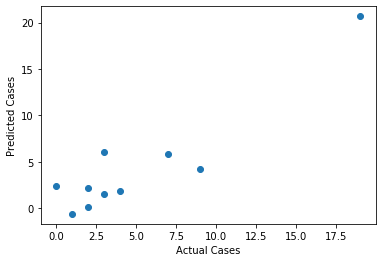

In [65]:
plt.scatter(y_test,predictions)
plt.xlabel('Actual Cases')
plt.ylabel('Predicted Cases')

In [64]:
from sklearn import metrics
print('MAE:', metrics.mean_absolute_error(y_test, predictions))
print('MSE:', metrics.mean_squared_error(y_test, predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))

MAE: 2.028314938784485
MSE: 5.468647581113248
RMSE: 2.3385139685520904
